# 必要なライブラリのインストール

# Googleドライブのマウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/Colab Notebooks/DLBasics2023_colab/submit/'

/content/drive/MyDrive/Colab Notebooks/DLBasics2023_colab/submit


# Lecture05のやり方を参考に改変

## ライブラリのインポート

In [22]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision import transforms as pth_transforms


import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

import random
import pandas as pd
from PIL import Image


rng = np.random.RandomState(1234)
random_state = 42


## 実験のために変数を一元管理

In [4]:
img_size = 224  # DINOの事前学習時の画像サイズ224に合わせたいが、GPUのメモリオーバーになってしまうのでいたしかたない
epochs_num = 7 # 動作確認のために小さくしている。精度を出したいときは大きくする。 100やるとかなり小さくなりそう
warmup_num = round(epochs_num/10, 0) # epocの10%くらい
batch_size = 16
val_rate = 0.3
learning_rate = 0.000001
num_classes = 2

## データセットの読み込みと可視化

In [5]:
from torch.utils.data import Dataset
import pandas as pd
import os


# PyTorchのDatasetクラスをサブクラス化して独自のクラスを作成
# trainかtestかで挙動を変えられるようにする

class CustomImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.labels_dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform


    def __len__(self):
        return len(self.labels_dataframe)

    def __getitem__(self, idx):
        # self.labels_dataframeに存在する画像ファイルのみ取り込む
        img_path = os.path.join(self.img_dir, self.labels_dataframe.iloc[idx, 0].split('-')[0], self.labels_dataframe.iloc[idx, 0].split('-')[1] + '.jpg')
        image = Image.open(img_path).convert('RGB')
        label = self.labels_dataframe.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label



In [6]:
# 画像データの前処理
transform = transforms.Compose([
    transforms.ToTensor(),
])


# データ
path_to_csv_file = './data/labels/labels_sensitivity_evaluation.csv'
path_to_images = './data/images/'

# データフレーム全体を読み込む
labels_dataframe = pd.read_csv(path_to_csv_file)

# 嗜好が3のものは除外する
labels_dataframe = labels_dataframe[labels_dataframe.iloc[:, 1]!=3]

# 2列目の値が1,2のものを0に変換
labels_dataframe.iloc[:, 1].replace([1, 2], 0, inplace=True)

# 2列目の値が4,5のものを1に変換
labels_dataframe.iloc[:, 1].replace([4, 5], 1, inplace=True)

# TrainValとtest用にデータを8:2に分割
trainval_df, test_df = train_test_split(labels_dataframe, test_size=0.2, random_state=42, stratify=labels_dataframe['label'])

# 分割したデータフレームをそれぞれのインスタンスに渡す。
trainval_data = CustomImageDataset(trainval_df, img_dir=path_to_images, transform=None)
test_data = CustomImageDataset(test_df, img_dir=path_to_images, transform=None)




In [7]:
print(trainval_df['label'].value_counts())
print(test_df['label'].value_counts())

1    104
0    104
Name: label, dtype: int64
0    26
1    26
Name: label, dtype: int64


## データ準備

In [8]:
def fix_seed(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


fix_seed(seed=42)


class gcn():
    def __init__(self):
        pass

    def __call__(self, x):
        mean = torch.mean(x)
        std = torch.std(x)
        return (x - mean)/(std + 10**(-6))  # 0除算を防ぐ




参考サイト
- Pystyle
  - Pytorch – torchvision で使える Transform まとめ
  - https://pystyle.info/pytorch-list-of-transforms/#outline__6_3

In [9]:

# 学習データと訓練データに分割
# 分布を維持したまま分けるオプションは存在しない/seedも固定できないので扱い注意
train_size = int(len(trainval_data) * (1- val_rate))
val_size = len(trainval_data) - train_size
train_data, val_data = torch.utils.data.random_split(trainval_data, [train_size, val_size])


# 前処理を定義
# データ拡張は汎化性能を高くするために訓練時には適用するが、性能評価の際には利用しない

GCN = gcn()




transform_train = transforms.Compose([
                                      # まず画像サイズを揃える
                                      transforms.Resize(img_size),           # 短辺がこの値になるようにリサイズ
                                      transforms.CenterCrop(img_size),      # 1辺がこの値の正方形になるように中心で切り抜き。だいたい猫は写真の中央あたりにうつっているので問題ないと考える

                                      # Data Augmentation（テンソル変換前） 精度がむしろ下がる
                                      # transforms.RandomHorizontalFlip(p=1.0),  # horizontally flipping
                                      # transforms.RandomRotation(degrees=(-5, 5)),  # random rotation
                                      # transforms.RandomCrop(32, padding=(4, 4, 4, 4), padding_mode='constant'),  # random cropping
                                      # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),   # Brightness, Contrast, Saturation


                                      # テンソル変換
                                      transforms.ToTensor(),


                                      # Data Augmentation（テンソル変換後） 精度がむしろ下がる
                                      # transforms.RandomErasing(p=0.8, scale=(0.02, 0.33), ratio=(0.3, 3.3)), # random erasing


                                      # Preprocessing
                                      GCN,
                                      # zca  # メモリ不足で実行できない
                                      ])

transform = transforms.Compose([
                                #まず画像サイズを揃える
                                transforms.Resize(img_size),           # 短辺がこの値になるようにリサイズ
                                transforms.CenterCrop(img_size),      # 1辺がこの値の正方形になるように中心で切り抜き。だいたい猫は写真の中央あたりにうつっているので問題ないと考える

                                # テンソル変換
                                transforms.ToTensor(),

                                # Preprocessing
                                GCN,
                                ])

# データセットに前処理を設定
trainval_data.transform = transform_train
test_data.transform = transform



dataloader_train = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=True
)

dataloader_test = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False
)

# DINOから転移学習

参考
- https://venoda.hatenablog.com/entry/2020/10/14/071440

In [10]:
# cosine scheduler
class CosineScheduler:
    def __init__(self, epochs, lr, warmup_length=5):
        """
        Arguments
        ---------
        epochs : int
            学習のエポック数．
        lr : float
            学習率．
        warmup_length : int
            warmupを適用するエポック数．
        """
        self.epochs = epochs
        self.lr = lr
        self.warmup = warmup_length

    def __call__(self, epoch):
        """
        Arguments
        ---------
        epoch : int
            現在のエポック数．
        """
        progress = (epoch - self.warmup) / (self.epochs - self.warmup)
        progress = np.clip(progress, 0.0, 1.0)
        lr = self.lr * 0.5 * (1. + np.cos(np.pi * progress))

        if self.warmup:
            lr = lr * min(1., (epoch+1) / self.warmup)

        return lr

def set_lr(lr, optimizer):
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

# DINOモデルのロード
model = torch.hub.load('facebookresearch/dino:main', 'dino_vits8')

# モデルの出力層の変更
in_features = model.blocks[-1].norm1.normalized_shape[0] # modelの最後の層を見つけて、そのin_featuresを取得 (DINOの場合、modelはVision Transformer (ViT) で、その中のblocksがトランスフォーマーの各層に対応)
model.head = torch.nn.Linear(in_features, num_classes)

# デバイスの設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# オプティマイザと損失関数の設定
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# 学習率スケジューラの設定
scheduler = CosineScheduler(epochs=epochs_num, lr=learning_rate, warmup_length=warmup_num)


Downloading: "https://github.com/facebookresearch/dino/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall8_pretrain/dino_deitsmall8_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_deitsmall8_pretrain.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 251MB/s]


In [12]:
# 訓練と検証のループ

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

dataloader_dict = {'train': dataloader_train, 'valid': dataloader_valid}



for epoch in range(epochs_num):
    # print('Epoch {}/{}'.format(epoch + 1, epochs_num))
    # print('-------------')

    for phase in ['train', 'valid']:
        if phase == 'train':
            # 学習モードに設定
            model.train()
        else:
            # 訓練モードに設定
            model.eval()

        # epochの損失和
        epoch_loss = 0.0
        # epochの正解数
        epoch_corrects = 0

        for inputs, labels in dataloader_dict[phase]:

            inputs = inputs.to(device)
            labels = labels.to(device)

            # optimizerを初期化
            optimizer.zero_grad()

            # 学習時のみ勾配を計算させる設定にする
            with torch.set_grad_enabled(phase == 'train'):

                outputs = model(inputs)

                # 損失を計算
                loss = criterion(outputs, labels)

                # ラベルを予測
                _, preds = torch.max(outputs, 1)
                # print(preds)

                # 訓練時は逆伝搬の計算
                if phase == 'train':
                    # 逆伝搬の計算
                    loss.backward()

                    # パラメータ更新
                    optimizer.step()

                # イテレーション結果の計算
                epoch_loss += loss.item() * inputs.size(0)

                # 正解数の合計を更新
                epoch_corrects += torch.sum(preds == labels.data)

        if phase == 'train':
            # 学習モードに設定
            epoch_loss_train = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc_train = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
        else:
            # 訓練モードに設定
            epoch_loss_val = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc_val = epoch_corrects.double() / len(dataloader_dict[phase].dataset)



    print('EPOCH: {}, Train [Loss: {:.3f}, Acc: {:.3f}], Valid [Loss: {:.3f}, Acc: {:.3f}]'.format(
        epoch,
        epoch_loss_train,
        epoch_acc_train,
        epoch_loss_val,
        epoch_acc_val
    ))

EPOCH: 0, Train [Loss: 14.384, Acc: 0.000], Valid [Loss: 13.047, Acc: 0.000]
EPOCH: 1, Train [Loss: 12.358, Acc: 0.000], Valid [Loss: 11.425, Acc: 0.000]
EPOCH: 2, Train [Loss: 10.690, Acc: 0.000], Valid [Loss: 10.023, Acc: 0.000]
EPOCH: 3, Train [Loss: 9.236, Acc: 0.000], Valid [Loss: 8.742, Acc: 0.000]
EPOCH: 4, Train [Loss: 7.924, Acc: 0.014], Valid [Loss: 7.583, Acc: 0.000]
EPOCH: 5, Train [Loss: 6.715, Acc: 0.021], Valid [Loss: 6.476, Acc: 0.000]
EPOCH: 6, Train [Loss: 5.610, Acc: 0.062], Valid [Loss: 5.417, Acc: 0.016]


# testデータで性能検証

In [13]:
model.eval()

t_true = []
t_pred = []
for data, labels in dataloader_test:

    data = data.to(device)

    # 順伝播
    y = model.forward(data)

    # 予測値を格納
    t_pred.extend(y.detach().cpu().numpy())

    # labelを格納
    t_true.extend(labels.numpy())


# numpy arraysに変換
t_pred = np.array(t_pred)
t_true = np.array(t_true)

# 予測の出力がロジットなので、確率に変換するためにシグモイド関数を適用
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

t_pred_sigmoid = sigmoid(t_pred[:, 1])

In [14]:
print(t_pred_sigmoid)

[0.99997985 0.9922219  0.8002255  0.99995387 0.9999862  0.9999356
 0.99999464 0.99969554 0.9995085  0.9998266  0.9998     0.9999908
 0.999931   0.9895326  0.9981154  0.99999046 0.99831945 0.99974567
 0.9999206  0.9999633  0.9995414  0.9999976  0.99925524 0.99999464
 0.9944811  0.9998702  0.9998871  0.99901307 0.9983021  0.9879723
 0.9996644  0.9998809  0.99934167 0.9961682  0.9999391  0.99982554
 0.99815303 0.99965537 0.9999908  0.99997437 0.9999893  0.9943305
 0.9998902  0.99894756 0.9994753  0.999948   0.99931157 0.99993753
 0.98135144 0.9999989  0.99993634 0.9999521 ]


### ROCカーブ

ROC AUC: 0.6597633136094675


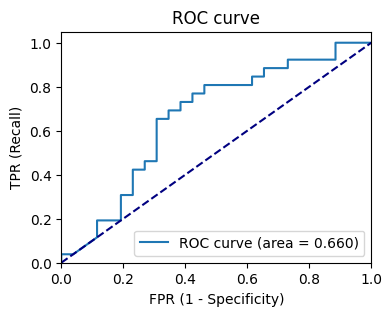

In [15]:
from sklearn.metrics import roc_curve

roc_auc = roc_auc_score(t_true, t_pred_sigmoid)
print(f"ROC AUC: {roc_auc}")

# ROCカーブの値を計算
fpr, tpr, thresholds = roc_curve(t_true, t_pred_sigmoid)

# ROCカーブをプロット
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR (1 - Specificity)')
plt.ylabel('TPR (Recall)')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

### 閾値を変更した場合の各指標の値

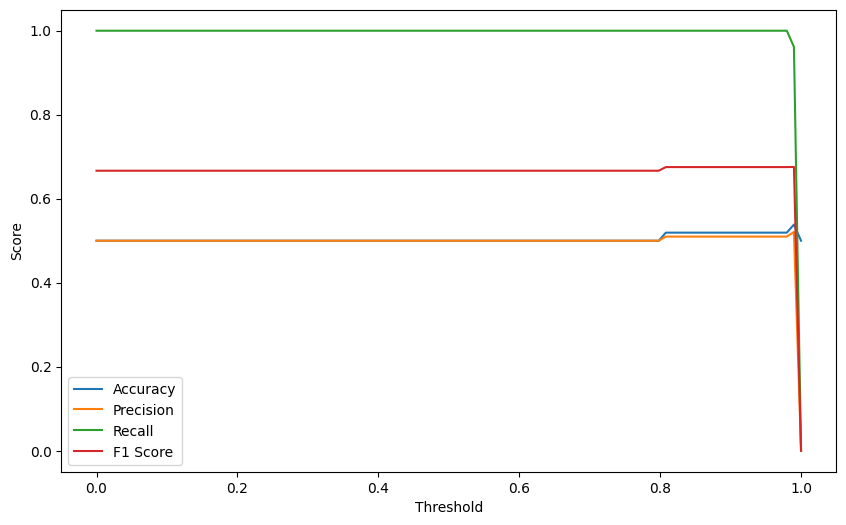

In [16]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# 様々な閾値で値を計算
thresholds = np.linspace(0, 1, 100)
accuracies = []
precisions = []
recalls = []
f1_scores = []
for threshold in thresholds:
    t_pred_class = (t_pred_sigmoid > threshold).astype(int)
    accuracies.append(accuracy_score(t_true, t_pred_class))
    precisions.append(precision_score(t_true, t_pred_class))
    recalls.append(recall_score(t_true, t_pred_class))
    f1_scores.append(f1_score(t_true, t_pred_class))

# 各指標をプロット
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracies, label='Accuracy')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()



### 混同行列

In [17]:
# 指定した閾値で混同行列を計算
threshold = 0.999999
t_pred_class = (t_pred_sigmoid > threshold).astype(int)
cm = confusion_matrix(t_true, t_pred_class)
print(f"混同行列の閾値 {threshold}:\n{cm}")

混同行列の閾値 0.999999:
[[26  0]
 [26  0]]


# Attention map

## 入力画像の読み込み

In [23]:
path_to_images_train = './data/images/'


In [24]:
from PIL import Image
import numpy as np

img_pil = Image.open("./data/images/CAT_00/00000007_007.jpg")
img_pil = img_pil.convert('RGB')

patch_size = 8

# 画像を NumPy 配列に変換
img_npy = np.array(img_pil)

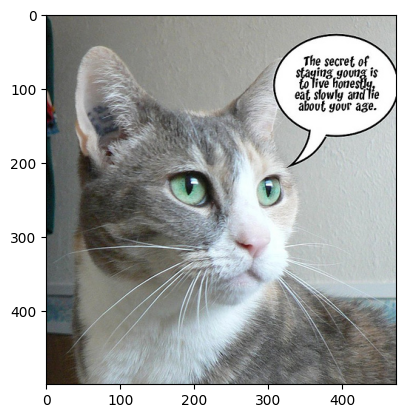

In [25]:
plt.imshow(img_npy)

## モデルからのattention mapの取得

In [26]:
transform = pth_transforms.Compose([
    pth_transforms.ToTensor(),
    pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
img = transform(img_npy)

# make the image divisible by the patch size
w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
img = img[:, :w, :h].unsqueeze(0)

w_featmap = img.shape[-2] // patch_size
h_featmap = img.shape[-1] // patch_size

attentions = model.get_last_selfattention(img.to(device))  # この関数に変更

In [27]:
nh = attentions.shape[1] # number of head

# we keep only the output patch attention
attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

# we keep only a certain percentage of the mass
val, idx = torch.sort(attentions)
val /= torch.sum(val, dim=1, keepdim=True)
cumval = torch.cumsum(val, dim=1)

In [28]:
threshold = 0.6 # We visualize masks obtained by thresholding the self-attention maps to keep xx% of the mass.
th_attn = cumval > (1 - threshold)
idx2 = torch.argsort(idx)
for head in range(nh):
    th_attn[head] = th_attn[head][idx2[head]]
th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()


th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().detach().numpy()

attentions = attentions.reshape(nh, w_featmap, h_featmap)
attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().detach().numpy()
attentions_mean = np.mean(attentions, axis=0)

## Attention mapの可視化

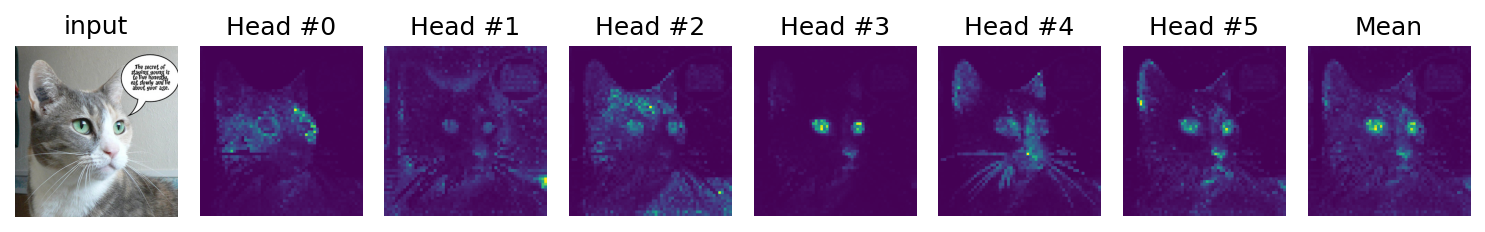

In [29]:
plt.figure(figsize=(10, 3), dpi=150)
plt.subplot(1, nh+2, 1)
plt.title("input")
plt.imshow(img_npy)
plt.axis("off")
# visualize self-attention of each head

for i in range(nh):
  plt.subplot(1, nh+2, i+2)
  plt.title("Head #"+str(i))
  plt.imshow(attentions[i])
  plt.axis("off")

plt.subplot(1, nh+2, nh+2)
plt.title("Mean")
plt.imshow(attentions_mean)
plt.axis("off")
plt.tight_layout()